# 다중공선성

다중공선성(multicollinearity)란 독립 변수의 일부가 다른 독립 변수의 조합으로 표현될 수 있는 경우이다. 독립 변수들이 서로 독립이 아니라 상호상관관계가 강한 경우에 발생한다. 이는 독립 변수의 공분산 행렬이 full rank 이어야 한다는 조건을 침해한다.

다음 데이터는 미국의 거시경제지표를 나타낸 것이다. 

* TOTEMP - Total Employment
* GNPDEFL - GNP deflator
* GNP - GNP
* UNEMP - Number of unemployed
* ARMED - Size of armed forces
* POP - Population
* YEAR - Year (1947 - 1962)

스캐터 플롯에서 보듯이 독립변수간의 상관관계가 강하다.

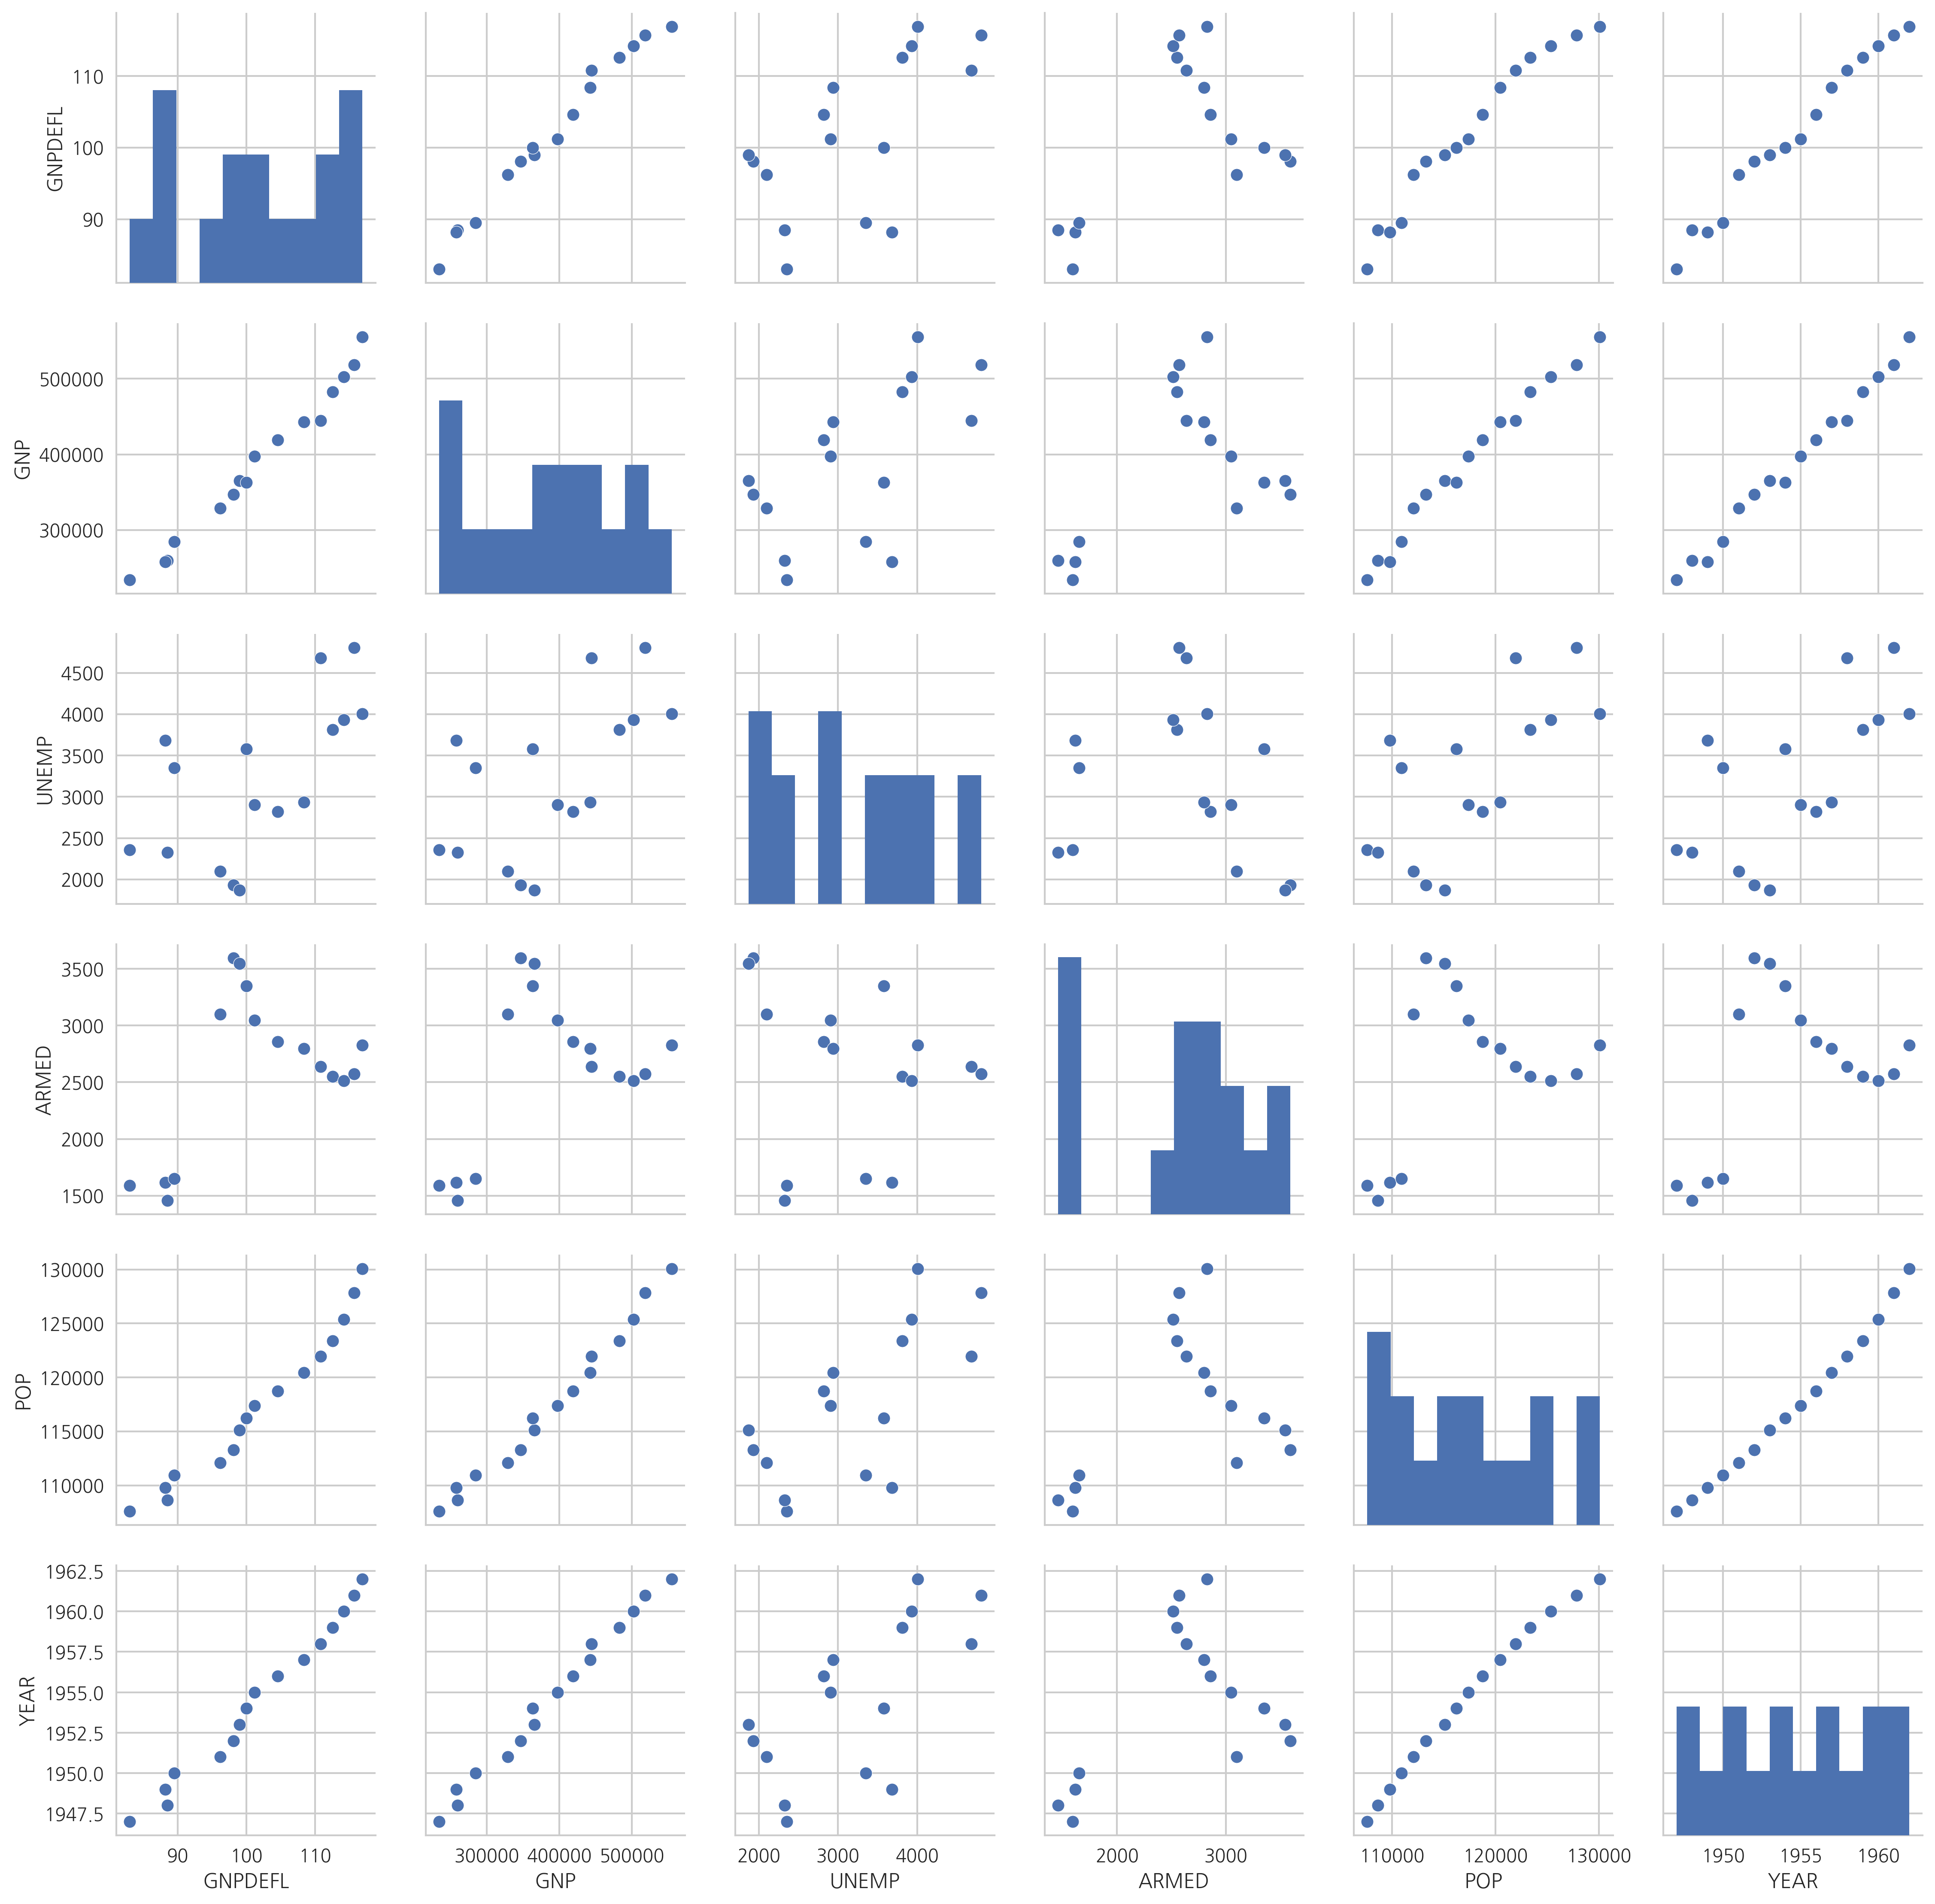

In [22]:
from statsmodels.datasets.longley import load_pandas
dfy = load_pandas().endog
dfX0 = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX0)
plt.show()

상관관계는 상관계수 행렬로도 살펴볼 수 있다.

In [28]:
dfX0.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


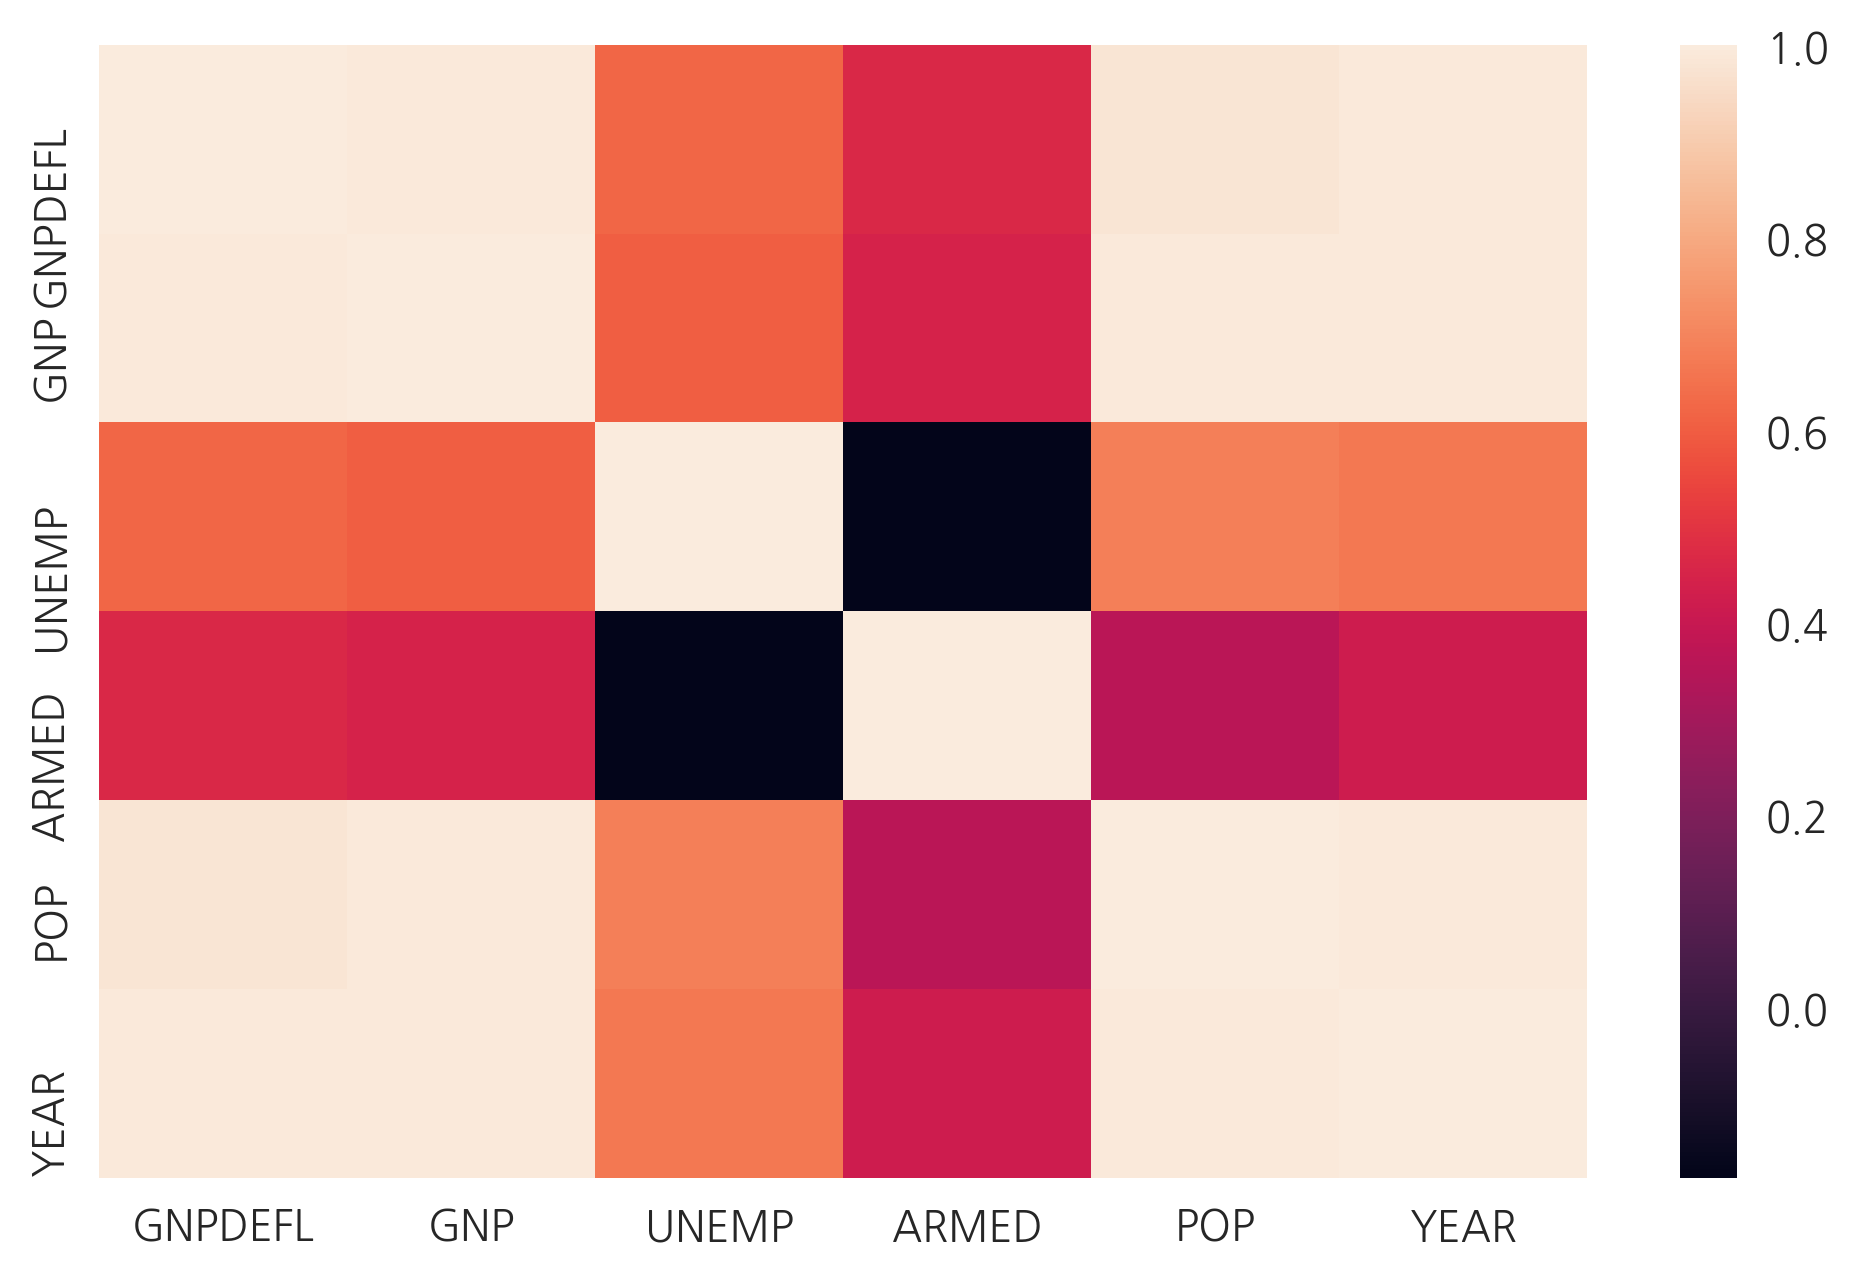

In [29]:
sns.heatmap(dfX0.corr())
plt.show()

다중 공선성이 있으면 독립변수의 공분산 행렬의 조건수(conditional number)가 증가한다.  조건수는 독립변수가 스케일링이 되어 있지 않아도 증가하므로 일단 스케일링을 통해 조건수를 감소시킨다.

In [20]:
model = sm.OLS.from_formula("TOTEMP ~ "
                            "scale(GNPDEFL) + scale(POP) + scale(GNP) + "
                            "scale(YEAR) + scale(ARMED) + scale(UNEMP)", data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Tue, 17 Oct 2017   Prob (F-statistic):           4.98e-10
Time:                        22:53:17   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6.532e+04     76.214    857.

/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


독립 변수가 서로 의존하게 되면 이른바 과최적화(over-fitting) 문제가 발생하여 회귀 결과의 안정성을 해치게 된다. 이를 방지하는 방법들은 다음과 같다.

* 변수 선택법으로 의존적인 변수 삭제
* PCA(principal component analysis) 방법으로 의존적인 성분 삭제
* 정규화(regularized) 방법 사용

## VIF

다중 공선성을 없애는 가장 기본적인 방법은 다른 독립변수에 의존하는 변수를 없애는 것이다. 가장 의존적인 독립변수를 선택하는 방법으로는 VIF(Variance Inflation Factor)를 사용할 수 있다. VIF는 독립변수를 다른 독립변수로 선형회귀한 성능을 나타낸 것이다. $i$번째 변수의 VIF는 다음과 같이 계산한다.

$$ \text{VIF}_i = \frac{\sigma^2}{(n-1)\text{Var}[X_i]}\cdot \frac{1}{1-R_i^2} $$

여기에서 $R^2_i$는 다른 변수로 $i$번째 변수를 선형회귀한 성능(결정계수)이다. 결정계수가 클수록 다른 변수에 의존적인 것이므로 VIF가 커진다.

StatsModels에서는 `variance_inflation_factor` 명령으로 VIF를 계산한다.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX0.values, i) for i in range(dfX0.shape[1])]
vif["features"] = dfX0.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


상관계수와 VIF를 사용하여 독립 변수를 선택하면 GNP, ARMED, UNEMP 세가지 변수만으로도 비슷한 수준의 성능이 나온다는 것을 알 수 있다.

In [34]:
model2 = sm.OLS.from_formula("TOTEMP ~ scale(GNP) + scale(ARMED) + scale(UNEMP)", data=df)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     264.4
Date:                Tue, 17 Oct 2017   Prob (F-statistic):           3.19e-11
Time:                        23:08:24   Log-Likelihood:                -119.16
No. Observations:                  16   AIC:                             246.3
Df Residuals:                      12   BIC:                             249.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.532e+04    119.824    545.106   

/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
